# Regression: predicting the price of a car

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

For this project, we'll use the car price dataset by CooperUnion from Kaggle: https://www.kaggle.com/CooperUnion/cardataset

<img src="images/car-prices-dataset.jpg">

In [2]:
df = pd.read_csv('data/car-price-processes.csv.gz')

In [3]:
len(df)

11914

There are 11 914 rows in the data

In [4]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,34500


It has the following fields:
    
* `make` — make of a car (BMW, Toyota, and so on)
* `model` — model of a car
* `year` — year when the car was manufactured
* `engine_fuel_type` — type of fuel the engine needs (diesel, electric, and so on)
* `engine_hp` — horsepower of the engine
* `engine_cylinders` — number of cylinders in the engine
* `transmission_type` — type of transmission (automatic or manual)
* `driven_wheels` — front, rear, all
* `number_of_doors` — number of doors a car has
* `market_category` — luxury, crossover, and so on
* `vehicle_size` — compact, midsize, or large
* `vehicle_style` — sedan or convertible
* `highway_mpg` — miles per gallon (mpg) on the highway
* `city_mpg` — miles per gallon in the city
* `msrp` — manufacturer’s suggested retail price

## Exploratory data analysis
### Price

Our goal is to predict the price of a car. Let's look at the distribution of prices:

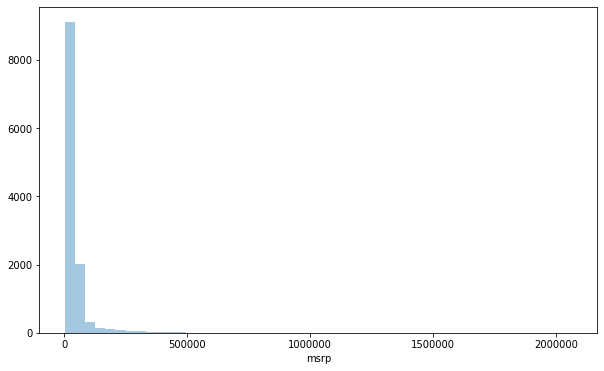

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(df.msrp, kde=False);

The data has long tail - it's hard to see anything. Let's zoom in a bit

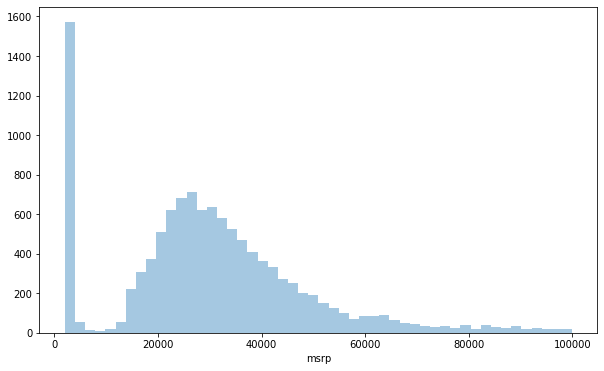

In [6]:
plt.figure(figsize=(10, 6))
sns.distplot(df.msrp[df.msrp < 100000], kde=False);

To remove the effect of the long tail, we need to apply log transformation:

$$y_\text{new} = \log(y + 1)$$

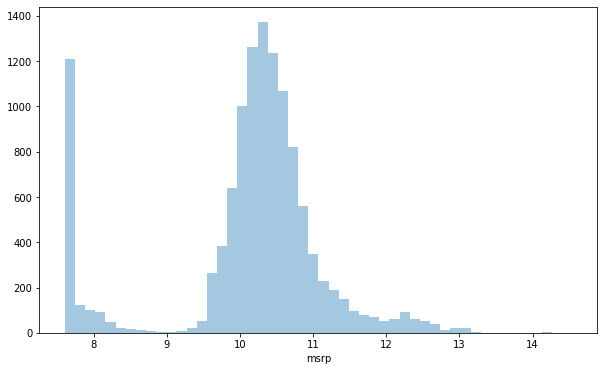

In [7]:
plt.figure(figsize=(10, 6))

log_price = np.log1p(df.msrp)
sns.distplot(log_price, kde=False);

The tail is gone now. When the distribution looks like that, it's easier for the model to predict the prices

<img src="images/normal_distribution.svg">

### Missing values

Not all machine learning models can deal with missing values. That's why we first need to check if some data is missing

In [8]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
msrp                    0
dtype: int64

We have 5 columns with missing data:

* `engine_fuel_type`
* `engine_hp`
* `engine_cylinders`
* `number_of_doors`
* `market_category`

## Training the model

### Splitting the data

We'll split the data into two parts: training and validation


<img src="images/validation_process.svg" />

**Note**: we do it for simplicity. You should split it into three parts: train, validation and test. Check [the book](https://mlbookcamp.com/) for more details

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=2)

In [11]:
len(df_train), len(df_val)

(9531, 2383)

We want to predict MSRP. Let's take it out from our dataframes, so we don't accidentally use it. We also need to apply the log transformation to it

In [12]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)

del df_train['msrp']
del df_val['msrp']

### Baseline

First start with all numeric variables. This is how we can select numeric columns in pandas:

To make it easier to use, let's create a list with variable names:

In [13]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [14]:
df_train[base].head()

,engine_hp,engine_cylinders,highway_mpg,city_mpg
4239,122.0,4.0,32,24
6937,NaN,0.0,100,91
1712,143.0,6.0,21,16
11742,310.0,6.0,27,19
6651,145.0,4.0,30,22


We already have $y$ - the target variable we want to predict. Now we need $X$ - the matrix with features. Let's create a function `prepare_X` that extract features from the dataframe and creates this matrix.

We previously checked that we have missing value in our data. For now we'll simple relace these values with zero, but later we'll look at other options.

In [15]:
def prepare_X(df):
    df_num = df[base].copy()
    df_num = df_num.fillna(0)

    X = df_num.values
    return X

In [16]:
X_train = prepare_X(df_train)

This is how the data looks like after preprocessing:

In [17]:
X_train

array([[122.,   4.,  32.,  24.],
       [  0.,   0., 100.,  91.],
       [143.,   6.,  21.,  16.],
       ...,
       [250.,   6.,  22.,  15.],
       [174.,   4.,  42.,  31.],
       [256.,   6.,  27.,  20.]])

In [18]:
X_train.shape

(9531, 4)

Now we have both $X$ and $y$, so let's train our model. We'll use `LinearRegression` from `sklearn.linear_model`

In [19]:
from sklearn.linear_model import LinearRegression

To train a model, we use the `fit` method:

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Instead of writing two lines, we can do it in one:

In [21]:
lr = LinearRegression().fit(X_train, y_train)

To predict, we use the `predict` method:

In [22]:
y_pred = lr.predict(X_train)

`y_pred` is an array with predictions for each row of the matrix `X_train`:

In [23]:
y_pred

array([ 9.30993738, 10.78966435,  8.9314132 , ...,  9.93529105,
       10.06467305, 10.14428166])

Let's compare the predictions with the predictions with the actual values:

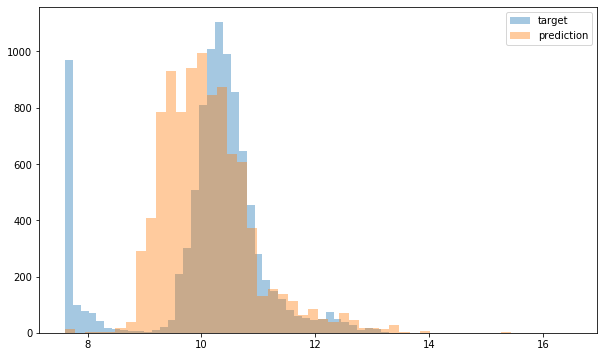

In [24]:
plt.figure(figsize=(10, 6))

sns.distplot(y_train, label='target', kde=False,)
sns.distplot(y_pred, label='prediction', kde=False,)

plt.legend()
plt.show()

We see that the distributions have quite different shapes, so probably our model is not good. To quantify the predictive performance of our model, we use metrics.

For regression, we often use RMSE: Root Mean Squared Error.

We don't have RMSE in sklearn, but we can use MSE (`mean_squared_error` in `sklearn.metrics`) and take a square root of it 

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
def rmse(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    return np.sqrt(mse)

Now we can use this function to evaluate the quality of our predictions:

In [27]:
rmse(y_train, y_pred)

0.7553190019101037

Instead of evaluating the quality of our model on training data, we use validation for that.

We don't yet have the feature matrix for that, so before we can do it, we need to extract $X$ from the validation dataframe 

In [28]:
X_val = prepare_X(df_val)

Now let's apply the model and calculate RMSE:

In [29]:
y_pred = lr.predict(X_val)

rmse(y_val, y_pred)

0.7410339726169998

### Adding more features

The process of extracting features from the dataframe is called "feature engineering". 

Let's engineer our first feature: age, which is the difference between the current year (2017 in the dataset) and the year when the car was manufactured.

We will create a new `prepare_X` function

In [30]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In this function we modify the dataframe: add a new column there. That's why we first take a copy, so it doesn't affect the original dataframe we pass in

Also, we create a list `features` with the features we'll use in $X$. First, we copy the `base` list, which contains the base numeric features we used previously, and then add `age` there 

Let's use this new function for training the model:

In [31]:
X_train = prepare_X(df_train)
X_train.shape

(9531, 5)

In [32]:
X_train = prepare_X(df_train)

lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_train)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = lr.predict(X_val)
print('validation', rmse(y_val, y_pred))

train 0.5201477505667936
validation 0.5281692888448396


RMSE improved from 0.75 to 0.51. Let's look at the distributions:

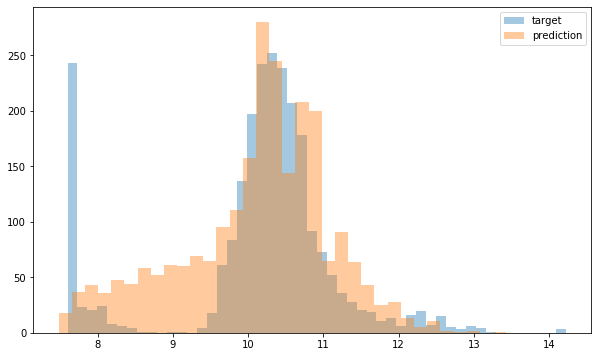

In [33]:
plt.figure(figsize=(10, 6))

sns.distplot(y_val, label='target', kde=False)
sns.distplot(y_pred, label='prediction', kde=False)

plt.legend()
plt.show()

The distribution of the predictions is now closer to the original one

## Using the model

Now that we have a trained model, we can use it to make predictions.
Let's check how to do it for a car from our test set (we didn't train our model on this data)

In [34]:
i = 0
ad = df_val.iloc[i].to_dict()
ad

{'make': 'chevrolet',
 'model': 'cobalt',
 'year': 2008,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 148.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'manual',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': nan,
 'vehicle_size': 'compact',
 'vehicle_style': 'coupe',
 'highway_mpg': 33,
 'city_mpg': 24}

To use the model:

* create a dataframe from this dictionary
* convert it to a matrix X (with one row)
* put it into the model
* get the first element from the resutls

In [35]:
X_test = prepare_X(pd.DataFrame([ad]))
y_pred = lr.predict(X_test)[0]
y_pred

9.419690630804002

We applied logarithmic transformation to our data. Let's undo it to get the actual price recommendation

In [36]:
suggestion = np.expm1(y_pred)
suggestion

12327.767488785634

We can compare it with the real price:

In [37]:
np.expm1(y_val[i]), suggestion

(14410.000000000002, 12327.767488785634)

## Saving and loading the model

In [38]:
import pickle

Saving the model

In [39]:
with open('price-model.bin', 'wb') as f_out:
    pickle.dump(lr, f_out)

Loading the model

In [40]:
with open('price-model.bin', 'rb') as f_in:
    lr = pickle.load(f_in)

In [41]:
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [43]:
car = {
    'year': 2008,
    'engine_hp': 148.0,
    'engine_cylinders': 4.0,
    'highway_mpg': 33,
    'city_mpg': 24
}

In [44]:
X_test = prepare_X(pd.DataFrame([car]))
y_pred = lr.predict(X_test)[0]
y_pred

9.419690630804002

In [45]:
X_test = prepare_X(pd.DataFrame([car]))
y_pred = lr.predict(X_test)[0]
np.expm1(y_pred)

12327.767488785634

In [46]:
X_test = prepare_X(pd.DataFrame([car]))
y_pred = lr.predict(X_test)[0]
np.expm1(y_pred).round(2)

12327.77

## Web service

```
DATA='{
    "year": 2008,
    "engine_hp": 148.0,
    "engine_cylinders": 4.0,
    "highway_mpg": 33,
    "city_mpg": 24
}'


curl -XPOST \
    --data "$DATA" \
    -H "Content-Type: application/json" \
    localhost:9696/predict
```